In [23]:
import os
import librosa
import librosa.display
import numpy as np

os.environ["TF_ENABLE_MLIR"] = "1"
os.environ["TF_GPU_THREAD_MODE"] = "gpu_private"
os.environ["TF_USE_LEGACY_GPU_KERNELS"] = "1"

import tensorflow as tf
from tensorflow.keras import layers, models

import matplotlib.pyplot as plt

In [3]:
import subprocess
subprocess.run(["system_profiler", "SPDisplaysDataType"])

Graphics/Displays:

    Apple M4 Max:

      Chipset Model: Apple M4 Max
      Type: GPU
      Bus: Built-In
      Total Number of Cores: 40
      Vendor: Apple (0x106b)
      Metal Support: Metal 3
      Displays:
        LS34A650U:
          Resolution: 3440 x 1440 (UWQHD - Ultra-Wide Quad HD)
          UI Looks like: 3440 x 1440 @ 100.00Hz
          Main Display: Yes
          Mirror: Off
          Online: Yes
          Rotation: Supported



CompletedProcess(args=['system_profiler', 'SPDisplaysDataType'], returncode=0)

In [ ]:
# Fixed spectrogram shape (H, W)
SPEC_HEIGHT = 128   # Mel filterbanks
SPEC_WIDTH = 344    # 344 # Ensures 5 seconds of time steps at 100 fps
AUDIO_LENGTH = 5    # Target audio length in seconds
SAMPLE_RATE = 16000  # 16kHz sample rate
F_MIN = 0
F_MAX = 1800
FIG_HEIGHT = SPEC_HEIGHT * 2
FIG_WIDTH = SPEC_WIDTH * 2

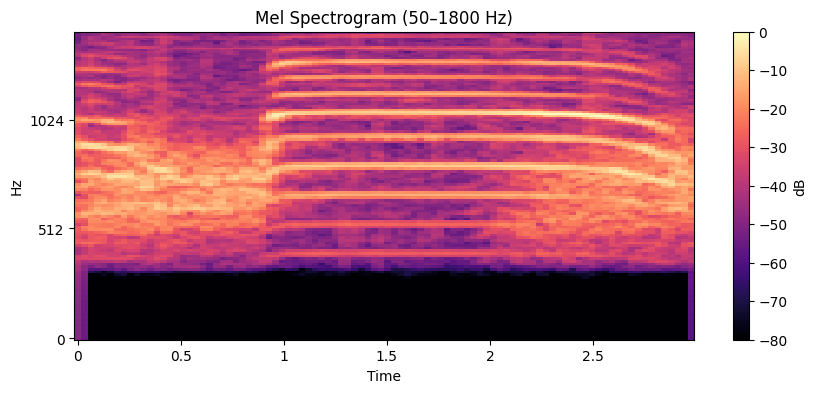

In [116]:
# Let's check out the spectrogram to see how it looks
# file_path = "/Users/ec/Documents/Data/Frog-Call-Classifier/_data/Example/Parsed_Capuchinbird_Clips/XC433953-0.wav"
file_path = "/Users/ec/Documents/Data/Frog-Call-Classifier/_data/Example/Parsed_Capuchinbird_Clips/XC395129-5.wav"
wav, sr = librosa.load(file_path, sr=16000)

# Compute new Mel spectrogram
mel_spec = librosa.feature.melspectrogram(y=wav, sr=sr, n_mels=128, fmin=F_MIN, fmax=F_MAX)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

# Plot
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spec_db, sr=sr, x_axis="time", y_axis="mel", fmin=F_MIN, fmax=F_MAX)
plt.colorbar(label="dB")
plt.title("Mel Spectrogram (50–1800 Hz)")
plt.show()

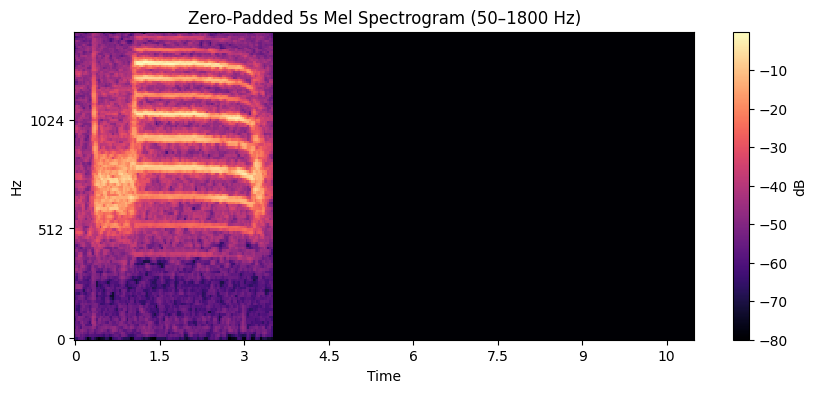

In [117]:
# file_path = "/Users/ec/Documents/Data/Frog-Call-Classifier/_data/Example/Parsed_Capuchinbird_Clips/XC395129-2.wav"
# file_path = "/Users/ec/Documents/Data/Frog-Call-Classifier/_data/Example/Parsed_Capuchinbird_Clips/XC433953-0.wav"
# file_path = "/Users/ec/Documents/Data/Frog-Call-Classifier/_data/Example/Parsed_Capuchinbird_Clips/XC395129-5.wav"
file_path = "/Users/ec/Documents/Data/Frog-Call-Classifier/_data/Example/Parsed_Capuchinbird_Clips/XC433953-10.wav"
wav, sr = librosa.load(file_path, sr=SAMPLE_RATE)

# Process spectrogram with 5s limit
mel_spec = librosa.feature.melspectrogram(y=wav[:SAMPLE_RATE * AUDIO_LENGTH], sr=sr, n_mels=128, fmin=F_MIN, fmax=F_MAX)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

# Zero pad
pad_width = [[0, 0], [0, max(0, SPEC_WIDTH - mel_spec_db.shape[1])]]
mel_spec_db_padded = np.pad(mel_spec_db, pad_width, mode='constant', constant_values=-80)

# Plot
plt.figure(figsize=(10, 4))
librosa.display.specshow(mel_spec_db_padded, sr=sr, x_axis="time", y_axis="mel", fmin=F_MIN, fmax=F_MAX)
plt.colorbar(label="dB")
plt.title("Zero-Padded 5s Mel Spectrogram (50–1800 Hz)")
plt.show()


In [126]:
def preprocess(file_path, label):
    # Convert TensorFlow tensor to a string
    file_path = file_path.numpy().decode('utf-8')

    # Load audio file
    wav, sr = librosa.load(file_path, sr=16000)  # Resample to 16kHz
    wav = librosa.util.fix_length(wav, size=sr * 3)  # Ensure 3 seconds

    # Convert to Mel spectrogram
    mel_spec = librosa.feature.melspectrogram(y=wav, sr=sr, n_mels=SPEC_HEIGHT)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)  # Convert to decibels

    # Ensure a fixed size using resizing
    mel_spec_db = np.expand_dims(mel_spec_db, axis=-1)  # Add channel dim
    mel_spec_db = tf.image.resize(mel_spec_db, (SPEC_HEIGHT, SPEC_WIDTH))  # Resize
    mel_spec_db.set_shape((SPEC_HEIGHT, SPEC_WIDTH, 1))

    # Normalize spectrogram values
    mel_spec_db = (mel_spec_db - tf.reduce_mean(mel_spec_db)) / tf.math.reduce_std(mel_spec_db)

    return mel_spec_db, label

In [ ]:
def preprocess(file_path, label):
    # Convert TensorFlow tensor to a string
    file_path = file_path.numpy().decode('utf-8')

    # Load audio file
    wav, sr = librosa.load(file_path, sr=SAMPLE_RATE)  

    # Ensure 5 seconds (trim or pad)
    target_length = AUDIO_LENGTH * sr
    if len(wav) < target_length:
        wav = np.pad(wav, (0, target_length - len(wav)), mode="constant")
    else:
        wav = wav[:target_length]

    # Compute Mel spectrogram (restricted to 50–800 Hz)
    mel_spec = librosa.feature.melspectrogram(y=wav, sr=sr, n_mels=SPEC_HEIGHT, fmin=50, fmax=800)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)  # Convert to dB scale

    # Zero-padding to ensure uniform time length (5s → 500 frames)
    pad_width = [[0, 0], [0, max(0, SPEC_WIDTH - mel_spec_db.shape[1])]]  
    mel_spec_db = np.pad(mel_spec_db, pad_width, mode='constant', constant_values=-80)  # -80 dB represents silence

    # Convert to TensorFlow tensor and normalize
    mel_spec_db = np.expand_dims(mel_spec_db, axis=-1)  # Add channel dim
    mel_spec_db = tf.convert_to_tensor(mel_spec_db, dtype=tf.float32)

    # Normalize spectrogram values (zero-centered)
    mel_spec_db = (mel_spec_db - tf.reduce_mean(mel_spec_db)) / tf.math.reduce_std(mel_spec_db)

    return mel_spec_db, label

In [127]:
# Apply function within a TensorFlow Dataset
def load_and_preprocess(file_path, label):
    spectrogram, label = tf.py_function(preprocess, [file_path, label], [tf.float32, tf.int32])
    spectrogram.set_shape((SPEC_HEIGHT, SPEC_WIDTH, 1))  # Ensure fixed shape
    return spectrogram, label

In [128]:
wd = os.getcwd().replace("/_scripts","")
POS = os.path.join(wd,'_data','Example', 'Parsed_Capuchinbird_Clips', '*.wav')
NEG = os.path.join(wd,'_data','Example','Parsed_Not_Capuchinbird_Clips', '*.wav')

# Load file paths
pos_files = tf.data.Dataset.list_files(POS, shuffle=False)
neg_files = tf.data.Dataset.list_files(NEG, shuffle=False)

# Check if files are loaded
print(f"Positive samples: {len(list(pos_files))}")
print(f"Negative samples: {len(list(neg_files))}")

Positive samples: 217
Negative samples: 593


2025-02-18 22:03:41.989562: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-18 22:03:42.005153: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [136]:
# Apply preprocessing
positives = pos_files.map(lambda x: load_and_preprocess(x, 1))
negatives = neg_files.map(lambda x: load_and_preprocess(x, 0))

# Combine datasets
data = positives.concatenate(negatives)

In [ ]:
# reshape the data
data = data.map(lambda x, y: (x, tf.reshape(y, [-1])))


In [139]:
# Split into training (80%) and testing (20%)
dataset_size = len(list(data))  # Count dataset size
test_size = int(0.2 * dataset_size)  # 20% test
train_size = dataset_size - test_size  # 80% train

# Take the first 80% as training data
train_data = data.take(train_size)

# Skip the first 80% and take the remaining 20% as test data
test_data = data.skip(train_size)

# Shuffle, batch, and prefetch
train_data = train_data.shuffle(1000).batch(16, drop_remainder=True).prefetch(tf.data.AUTOTUNE)
test_data = test_data.batch(16, drop_remainder=True).prefetch(tf.data.AUTOTUNE)  # No shuffle for test set

2025-02-18 22:07:01.149768: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [11]:
# Shuffle, batch, and prefetch
# data = data.shuffle(1000).batch(16, drop_remainder=True).prefetch(tf.data.AUTOTUNE)

In [84]:
dataset_size = sum(1 for _ in data)
print(f"Final dataset size: {dataset_size}")

dataset_size_train = sum(1 for _ in train_data)
print(f"Training dataset size: {dataset_size_train}")

dataset_size_test = sum(1 for _ in test_data)
print(f"Testing dataset size: {dataset_size_test}")

2025-02-18 21:55:01.730527: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Final dataset size: 810


2025-02-18 21:55:13.352873: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Training dataset size: 40
Testing dataset size: 10


2025-02-18 21:55:28.158189: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [135]:
for sample_wav, sample_label in train_data.take(1):
    print("Waveform shape:", sample_wav.shape) # Expected: (16, 128, 344, 1)
    print("Label shape:", sample_label.shape) # Expected: (16,)
    print("Label values:", sample_label.numpy())

Waveform shape: (16, 128, 344, 1)
Label shape: (16,)
Label values: [0 0 0 0 0 1 1 0 1 0 0 0 1 0 1 1]


2025-02-18 22:05:25.148553: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [140]:
# Define CNN Model
def build_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(SPEC_HEIGHT, SPEC_WIDTH, 1)),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])
    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

model = build_model()
model.summary()


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_27 (Conv2D)              │ (None, 126, 342, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 126, 342, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_27 (MaxPooling2D) │ (None, 63, 171, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_28 (Conv2D)              │ (None, 61, 169, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 61, 169, 64)    │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_28 (MaxPooling2D) │ (None, 30, 84, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_29 (Conv2D)              │ (None, 28, 82, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 28, 82, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 14, 41, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_9 (Flatten)             │ (None, 73472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 128)            │     9,404,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,506,433 (36.26 MB)

 Trainable params: 9,505,985 (36.26 MB)

 Non-trainable params: 448 (1.75 KB)

In [141]:
print(f"Model expects: {model.input_shape}")


Model expects: (None, 128, 344, 1)


In [ ]:
# Train the model
history = model.fit(train_data, epochs=18)

Epoch 1/18
40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 28ms/step - accuracy: 0.8480 - loss: 9.0650
Epoch 2/18
40/40 ━━━━━━━━━━━━━━━━━━━━ 14s 31ms/step - accuracy: 0.9760 - loss: 1.5069
Epoch 3/18
40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - accuracy: 0.9577 - loss: 8.5950
Epoch 4/18
40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - accuracy: 0.9797 - loss: 2.8605
Epoch 5/18
40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - accuracy: 0.9740 - loss: 3.3549
Epoch 6/18
40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step - accuracy: 0.9839 - loss: 3.9015
Epoch 7/18
40/40 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - accuracy: 0.9917 - loss: 1.1441
Epoch 8/18
40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - accuracy: 0.9899 - loss: 1.7815
Epoch 9/18
40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - accuracy: 0.9875 - loss: 1.8309
Epoch 10/18
40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - accuracy: 0.9982 - loss: 0.1432
Epoch 11/18
40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 31ms/step - accuracy: 0.9947 - loss: 1.3480
Epoch 12/18
40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 32ms/step

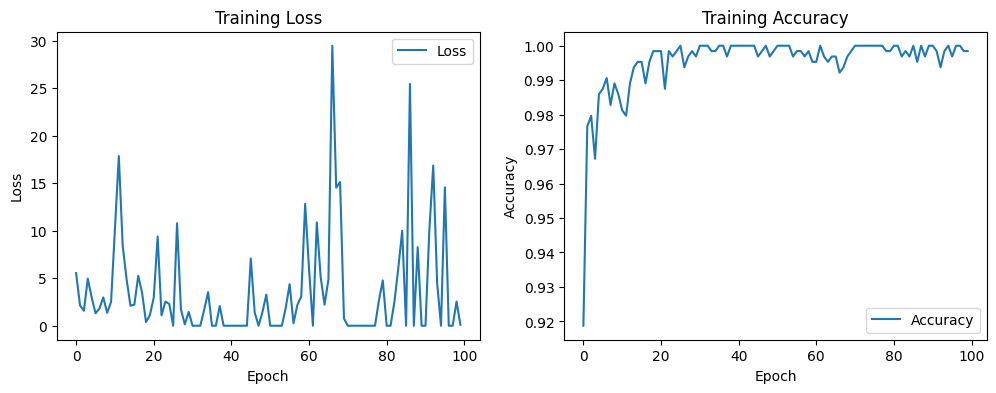

In [19]:
# Extract loss and accuracy values
loss = history.history['loss']
accuracy = history.history['accuracy']

# Plot loss curve
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(loss, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Plot accuracy curve
plt.subplot(1, 2, 2)
plt.plot(accuracy, label='Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()

plt.show()


In [20]:
final_loss = history.history['loss'][-1]
final_accuracy = history.history['accuracy'][-1]
print(f"Final Training Loss: {final_loss:.4f}")
print(f"Final Training Accuracy: {final_accuracy:.4f}")


Final Training Loss: 0.0991
Final Training Accuracy: 0.9984


In [21]:
test_loss, test_acc = model.evaluate(test_data)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 15s 309ms/step - accuracy: 0.9935 - loss: 76.5251
Test Loss: 248.4317
Test Accuracy: 0.9812


In [22]:
sample_batch = next(iter(test_data.take(1)))  # Get one batch from test data
sample_spectrograms, sample_labels = sample_batch

predictions = model.predict(sample_spectrograms)
predictions = (predictions > 0.5).astype(int)  # Convert probabilities to binary labels

print("Predicted Labels:", predictions.flatten())
print("Actual Labels:   ", sample_labels.numpy().flatten())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
Predicted Labels: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Actual Labels:    [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
